In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv('train_boston.csv')
df1.head()

index          id     data   bedrooms   bathrooms   sqft_living   sqft_lot  \
0   6243  8850000509  9/23/14          2        1.50          1620       1444   
1   8986   191100410  6/20/14          3        2.75          2470      10125   
2   9419  6632300040  4/25/15          2        1.00          1140       7435   
3  10155  7517500310   5/6/15          3        1.00          1460       6198   
4  10436  7454000990  9/24/14          2        1.00           670       6720   

    floors   waterfront   view  ...   sqft_above   sqft_basement   yr_built  \
0      2.0            0      0  ...         1080             540       2007   
1      2.0            0      0  ...         2470               0       1960   
2      1.0            0      0  ...         1140               0       1952   
3      1.5            0      0  ...         1460               0       1916   
4      1.0            0      0  ...          670               0       1942   

    yr_renovated   zip_code      lat      lon   sqft_living15   sqft_lot15  \
0              0      98144  47.5892 -122.309            1660         1642   
1           2012      98040  47.5651 -122.223            2290        10125   
2           1990      98125  47.7300 -122.310            1320         9385   
3              0      98107  47.6626 -122.361            2280         5160   
4              0      98126  47.5151 -122.372             710         6720   

    price  
0  525000  
1  970500  
2  327000  
3  775000  
4  304950  

[5 rows x 22 columns]

# Data Cleaning

In [3]:
df1.columns = [column.replace(' ','') for column in df1.columns]
df1.columns

Index(['index', 'id', 'data', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zip_code',
       'lat', 'lon', 'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [4]:
#dropping useless columns
df1 = df1.drop(['index','lat','lon', 'id'], axis=1)

In [5]:
nulls = pd.DataFrame(df1.isna().sum()*100/len(df1), columns=['percentage'])
nulls.sort_values('percentage', ascending = False)

percentage
data                  0.0
bedrooms              0.0
sqft_lot15            0.0
sqft_living15         0.0
zip_code              0.0
yr_renovated          0.0
yr_built              0.0
sqft_basement         0.0
sqft_above            0.0
grade                 0.0
condition             0.0
view                  0.0
waterfront            0.0
floors                0.0
sqft_lot              0.0
sqft_living           0.0
bathrooms             0.0
price                 0.0

In [6]:
df1.dtypes

data              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zip_code           int64
sqft_living15      int64
sqft_lot15         int64
price              int64
dtype: object

In [35]:
#changing data types of these columns because it makes more sense to treat them as objects and encode them
df1[['bathrooms','bedrooms','view','waterfront','floors','condition','grade','zip_code', 'yr_built', 'yr_renovated']] = df1[['bathrooms','bedrooms','view','waterfront','floors','condition','grade','zip_code', 'yr_built', 'yr_renovated']].astype('object')

In [36]:
df1['data']= pd.to_datetime(df1['data'])

In [37]:
df1.dtypes

data             datetime64[ns]
bedrooms                 object
bathrooms                object
sqft_living               int64
sqft_lot                  int64
floors                   object
waterfront               object
view                     object
condition                object
grade                    object
sqft_above                int64
sqft_basement             int64
yr_built                 object
yr_renovated             object
zip_code                 object
sqft_living15             int64
sqft_lot15                int64
price                     int64
dtype: object

In [38]:
#Intuitively, the target variable has a high correlation with square feet. Counterintuitively, it's not highly correlated at first with the year built and year renovated, I understand it's because this has nothing to do with the quality of the building
df1.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.705890
sqft_above       0.607706
sqft_living15    0.585543
sqft_basement    0.331291
sqft_lot         0.092304
sqft_lot15       0.089045
Name: price, dtype: float64

In [39]:
'''def years(x):
    if x['yr_renovated'] == 0:
        return x['data']-x['yr_built']
    else:
        return x['data']-x['yr_renovated']
df1['yrs_until_sold']=df1.apply(years, axis=1)
df1'''

"def years(x):\n    if x['yr_renovated'] == 0:\n        return x['data']-x['yr_built']\n    else:\n        return x['data']-x['yr_renovated']\ndf1['yrs_until_sold']=df1.apply(years, axis=1)\ndf1"

In [40]:
#bucketing zip codes?

In [41]:
#separar num i cat
data_num = df1.select_dtypes(np.number)
data_cat = df1.select_dtypes(np.object)

# EDA

In [42]:
df1.describe()

sqft_living      sqft_lot    sqft_above  sqft_basement  sqft_living15  \
count  17276.000000  1.727600e+04  17276.000000   17276.000000   17276.000000   
mean    2084.123177  1.508619e+04   1791.053542     293.069634    1988.115825   
std      924.621058  4.147208e+04    830.925292     445.900684     687.864331   
min      370.000000  5.200000e+02    370.000000       0.000000     460.000000   
25%     1420.000000  5.030000e+03   1190.000000       0.000000    1490.000000   
50%     1920.000000  7.599000e+03   1570.000000       0.000000    1840.000000   
75%     2556.250000  1.069850e+04   2220.000000     560.000000    2360.000000   
max    13540.000000  1.651359e+06   9410.000000    4820.000000    6210.000000   

          sqft_lot15         price  
count   17276.000000  1.727600e+04  
mean    12648.988307  5.408807e+05  
std     25805.732442  3.732611e+05  
min       651.000000  8.000000e+04  
25%      5100.000000  3.210202e+05  
50%      7614.000000  4.500000e+05  
75%     10093.250000  6.442125e+05  
max    560617.000000  7.700000e+06

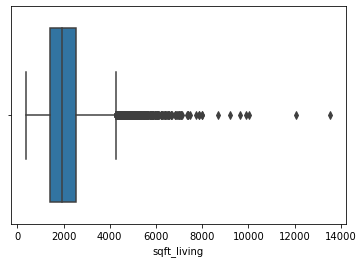

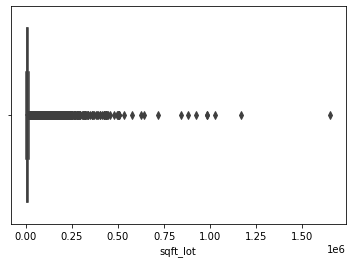

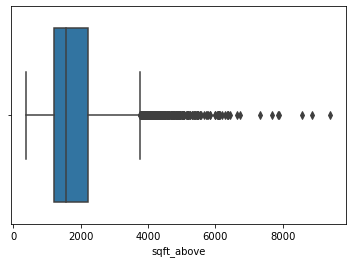

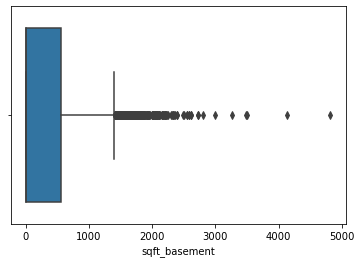

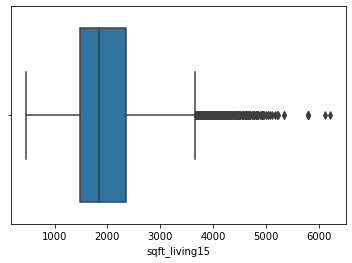

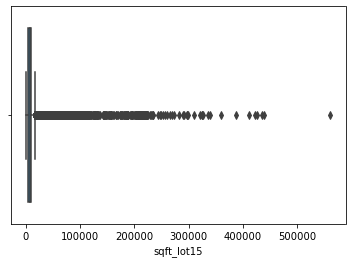

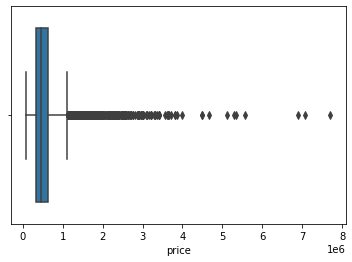

In [43]:
for column in df1.select_dtypes(np.number).columns:
    sns.boxplot(df1[column])
    plt.show()

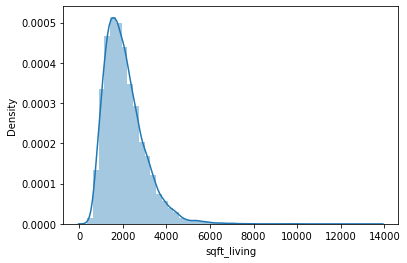

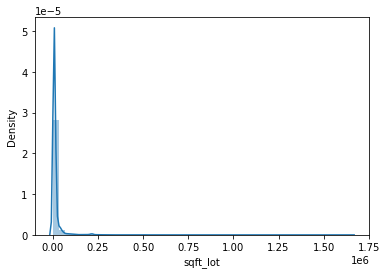

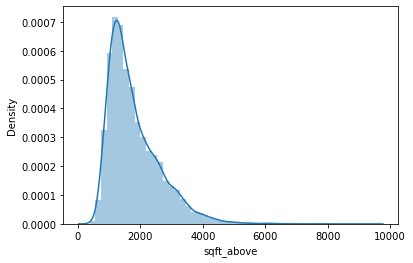

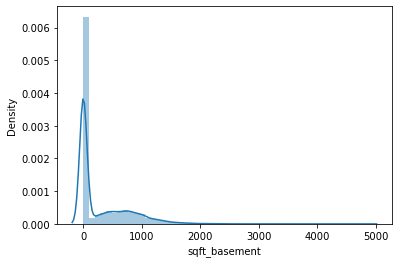

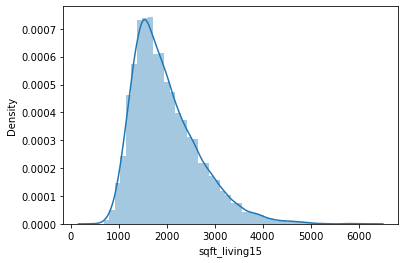

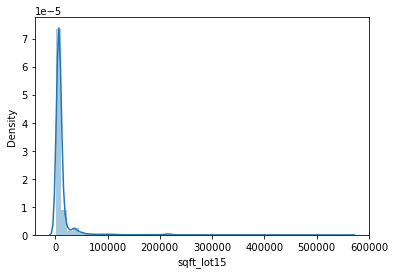

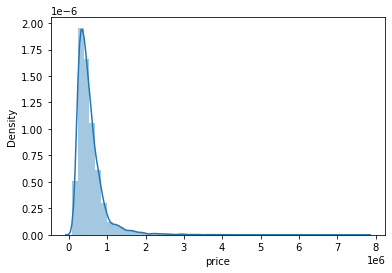

In [44]:
for column in df1.select_dtypes(np.number).columns:
    sns.distplot(df1[column])
    plt.show()

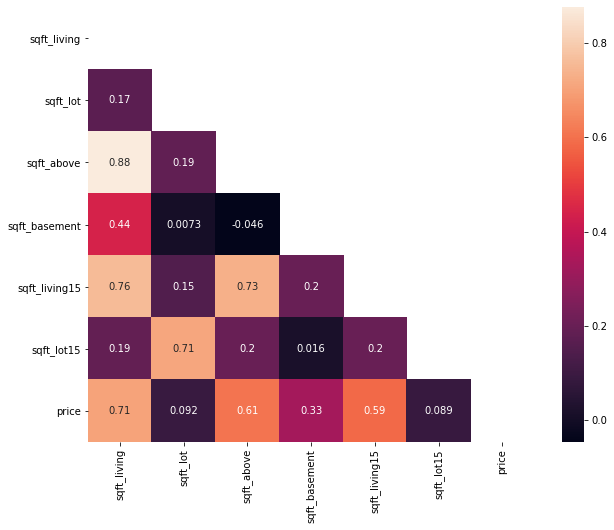

In [45]:
# check the correlations
mask = np.zeros_like(df1.corr())

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(df1.corr(), mask=mask, annot=True)
plt.show()

# Dealing with outliers

In [46]:
for column in data_num:
    upper = np.percentile(data_num[column],75)
    lower = np.percentile(data_num[column],25)
    iqr = upper - lower
    upper_limit = upper + 1.5 * iqr
    lower_limit = lower - 1.5 * iqr
    clean_data_num = data_num[(data_num[column]>lower_limit) & (data_num[column]<upper_limit)]

# Feature scaling

In [61]:
#log boxcox. At first this gave me a R2 of 0,002 because it applied the log to Year, so it made it much more tied
#So I turned the yr_built and yr_renovated into objects
def boxcox_transform(clean_data_num):
    numeric_cols = clean_data_num.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        clean_data_num[column] = np.where(clean_data_num[column]<=0, np.NAN, clean_data_num[column])
        clean_data_num[column] = clean_data_num[column].fillna(clean_data_num[column].mean())
        transformed_data, ci = stats.boxcox(clean_data_num[column])
        clean_data_num[column] = transformed_data
        _ci[column] = ci
    return clean_data_num, _ci

In [62]:
clean_data_num, _ci = boxcox_transform(clean_data_num)

In [63]:
#adding clean numericals & categoricals
table = data_cat.merge(clean_data_num, right_index=True, left_index=True)
table

bedrooms bathrooms floors waterfront view condition grade yr_built  \
0            2       1.5      2          0    0         3     9     2007   
1            3      2.75      2          0    0         3     8     1960   
2            2         1      1          0    0         3     7     1952   
3            3         1    1.5          0    0         4     7     1916   
4            2         1      1          0    0         5     6     1942   
...        ...       ...    ...        ...  ...       ...   ...      ...   
17271        2      1.75      1          0    0         3     8     1962   
17272        3      2.25      3          0    0         3     8     2008   
17273        6      1.75    2.5          0    0         4     9     1908   
17274        3         1      1          0    0         3     7     1951   
17275        5         2    1.5          0    0         3     6     1947   

      yr_renovated zip_code  sqft_living  sqft_lot  sqft_above  sqft_basement  \
0                0    98144    14.839224  5.358232    2.451404     162.656169   
1             2012    98040    16.570859  6.435651    2.607969     200.053769   
2             1990    98125    13.497256  6.285782    2.462440     200.053769   
3                0    98107    14.432873  6.193961    2.511451     200.053769   
4                0    98126    11.627733  6.235089    2.348599     200.053769   
...            ...      ...          ...       ...         ...            ...   
17271         1980    98027    15.281373  6.291628    2.467700     185.709284   
17272            0    98103    13.656499  5.238485    2.471117     200.053769   
17273            0    98122    17.296707  6.082142    2.628330      56.041220   
17274            0    98115    12.681929  6.104055    2.415650     200.053769   
17275            0    98118    14.352684  6.141610    2.507430     200.053769   

       sqft_living15  sqft_lot15      price  
0           3.285757    5.695141  44.528081  
1           3.380872    6.735738  49.925602  
2           3.215159    6.698259  40.720424  
3           3.379609    6.385554  47.886861  
4           3.011510    6.527494  40.183251  
...              ...         ...        ...  
17271       3.354318    6.586274  44.138615  
17272       3.179731    5.497216  43.698636  
17273       3.344326    6.368211  48.424242  
17274       3.258903    6.493386  45.145223  
17275       3.319911    6.465568  34.242516  

[16333 rows x 17 columns]

# Dummifying

In [50]:
df2 = df1.copy()
df2 = pd.get_dummies(table, drop_first=True)
df2

sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
0        16.113291  3.969701    3.931261     163.031231       4.577087   
1        17.891305  4.386643    4.143476     200.247817       4.686361   
2        14.736630  4.330256    3.946139     200.247817       4.496132   
3        15.696314  4.295466    4.012363     200.247817       4.684908   
4        12.820801  4.311072    3.793251     200.247817       4.263353   
...            ...       ...         ...            ...            ...   
17271    16.567116  4.332465    3.953234     185.973599       4.655830   
17272    14.899929  3.921569    3.957846     200.247817       4.455556   
17273    18.637095  4.252846    4.171253      56.878654       4.644347   
17274    13.900803  4.261221    3.883141     200.247817       4.546278   
17275    15.614041  4.275548    4.006921     200.247817       4.616298   

       sqft_lot15      price  bedrooms_2  bedrooms_3  bedrooms_4  ...  \
0        3.873077  46.535772           1           0           0  ...   
1        4.222698  52.096843           0           1           0  ...   
2        4.210501  42.615769           1           0           0  ...   
3        4.107641  49.995764           0           1           0  ...   
4        4.154576  42.062963           1           0           0  ...   
...           ...        ...         ...         ...         ...  ...   
17271    4.173892  46.134695           1           0           0  ...   
17272    3.803767  45.681630           0           1           0  ...   
17273    4.101877  50.549512           0           0           0  ...   
17274    4.143336  47.171367           0           1           0  ...   
17275    4.134150  35.953223           0           0           0  ...   

       zip_code_98146  zip_code_98148  zip_code_98155  zip_code_98166  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
17271               0               0               0               0   
17272               0               0               0               0   
17273               0               0               0               0   
17274               0               0               0               0   
17275               0               0               0               0   

       zip_code_98168  zip_code_98177  zip_code_98178  zip_code_98188  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
17271               0               0               0               0   
17272               0               0               0               0   
17273               0               0               0               0   
17274               0               0               0               0   
17275               0               0               0               0   

       zip_code_98198  zip_code_98199  
0                   0               0  
1                   0               0  
2                   0               0  
3                   0               0  
4                   0               0  
...               ...             ...  
17271               0               0  
17272               0               0  
17273               0               0  
17274               0               0  
17275               0               0  

[16333

# ML model - LR

In [52]:
#splitting our data
X = df2.drop(['price'], axis=1)
y = df2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
df2

sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
0        16.113291  3.969701    3.931261     163.031231       4.577087   
1        17.891305  4.386643    4.143476     200.247817       4.686361   
2        14.736630  4.330256    3.946139     200.247817       4.496132   
3        15.696314  4.295466    4.012363     200.247817       4.684908   
4        12.820801  4.311072    3.793251     200.247817       4.263353   
...            ...       ...         ...            ...            ...   
17271    16.567116  4.332465    3.953234     185.973599       4.655830   
17272    14.899929  3.921569    3.957846     200.247817       4.455556   
17273    18.637095  4.252846    4.171253      56.878654       4.644347   
17274    13.900803  4.261221    3.883141     200.247817       4.546278   
17275    15.614041  4.275548    4.006921     200.247817       4.616298   

       sqft_lot15      price  bedrooms_2  bedrooms_3  bedrooms_4  ...  \
0        3.873077  46.535772           1           0           0  ...   
1        4.222698  52.096843           0           1           0  ...   
2        4.210501  42.615769           1           0           0  ...   
3        4.107641  49.995764           0           1           0  ...   
4        4.154576  42.062963           1           0           0  ...   
...           ...        ...         ...         ...         ...  ...   
17271    4.173892  46.134695           1           0           0  ...   
17272    3.803767  45.681630           0           1           0  ...   
17273    4.101877  50.549512           0           0           0  ...   
17274    4.143336  47.171367           0           1           0  ...   
17275    4.134150  35.953223           0           0           0  ...   

       zip_code_98146  zip_code_98148  zip_code_98155  zip_code_98166  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
17271               0               0               0               0   
17272               0               0               0               0   
17273               0               0               0               0   
17274               0               0               0               0   
17275               0               0               0               0   

       zip_code_98168  zip_code_98177  zip_code_98178  zip_code_98188  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
17271               0               0               0               0   
17272               0               0               0               0   
17273               0               0               0               0   
17274               0               0               0               0   
17275               0               0               0               0   

       zip_code_98198  zip_code_98199  
0                   0               0  
1                   0               0  
2                   0               0  
3                   0               0  
4                   0               0  
...               ...             ...  
17271               0               0  
17272               0               0  
17273               0               0  
17274               0               0  
17275               0               0  

[16333

In [54]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [55]:
predictions = model.predict(X_test)

In [56]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [57]:
print('The R2_score is',r2_score(y_test, predictions))
print ('The mean_absolute_error is', mean_absolute_error(y_test, predictions))
print('The mean_squared error is', mean_squared_error(y_test, predictions, squared=False))

The R2_score is 0.8622303809123699
The mean_absolute_error is 0.9959140971992483
The mean_squared error is 1.3602685533372791


<AxesSubplot:ylabel='price'>

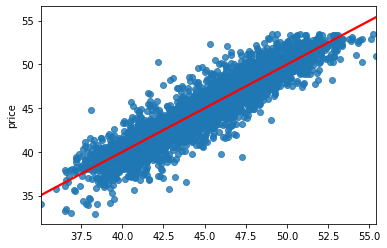

In [58]:
sns.regplot(predictions, y_test, line_kws={'color': 'red'})

In [59]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [60]:
knn.score(X_test, y_test)

0.5010252862422425

# Random forest